<a href="https://colab.research.google.com/github/evakosova/Machine_learning/blob/main/ML_OpenVsGlobular_clusters_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beginning

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split 

In [2]:
PATH = "drive/MyDrive/Colab Notebooks/ML_exam/images"  #directory to folders with images
categories = ['open', 'globular'] 

#creating dataset with all the images
Mydataset = []
def create_dataset():
    IMG_SIZE = 100     #how many pixels should the new images have
    for i in categories:   #creating loop to get through all images
        path = os.path.join(PATH, i)  #path to open clusters and globular clusters
        classification = categories.index(i)  #classification - 0 for open cluster, 1 for globular cluster
        for img in os.listdir(path):  #with lstdir we create list of images
            img_list = cv2.imread(os.path.join(path,img))  #load image from our path
            new_list = cv2.resize(img_list, (IMG_SIZE,IMG_SIZE))   #resizing the original images 
            Mydataset.append([new_list, classification])

create_dataset()
print(len(Mydataset)) #checking how many images are in the final dataset

1092


In [3]:
import random

random.shuffle(Mydataset) #randomly shuffling my dataset
#to make sure the shuffel worked well, I will look at the classification of first 20 images 
#0=open cluster
#1=globular cluster
for image in Mydataset[:20]:
  print(image[1]) #vypíšeme si druhý sloupeček v našem datasetu, které udávají labely obrázku (open=0, globular=1)

0
0
0
0
1
0
1
1
0
1
1
1
0
1
0
1
0
1
0
1


In [4]:
#z původního formátu dat (list) vytvoříme formát array, který nám model zvládne zpracovat
x_data = []
y_data = []
for img_x,label in Mydataset[:]:
  x_data.append(img_x)
  y_data.append(label) 

x_data = np.array(x_data)
y_data = np.array(y_data)
#print(x_data)
#print(y_data)
print(x_data.shape) #můžeme se podívat na parametry vytvořeného pole (pošet položek, rozměry v x a y, barevnost)
print(y_data.shape) 

(1092, 100, 100, 3)
(1092,)


# Deviding & verifying data 

In [5]:
#dataset si rozdělíme na trénovací a testovací data, pomě trénovacích a testovacích bude 7:3 
x_train,x_test,y_train,y_test = train_test_split(x_data, y_data, train_size=0.7)

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

print(x_train.shape) #kolik máme nakonec trénovacích dat
print(np.bincount(y_train)) #zastoupení jednotlivých tříd objektů, mělo by být cca rovnoměrné

(764, 100, 100, 3)
[423 341]


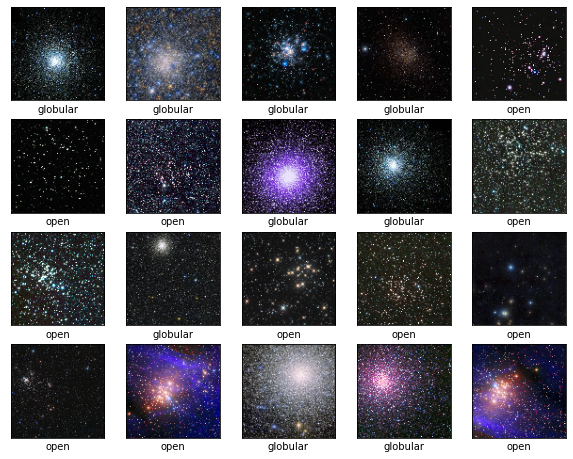

First 10 train labels:
1
1
1
1
0
0
0
1
1
0


In [6]:
import matplotlib.pyplot as plt

#ploting first 20 images in dataset to verify the data
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(categories[y_train[i]])
plt.show()

#plotnutí prvních 10 labelů v trénovacích datech
print ('First 10 train labels:')
for item in y_train[0:10]:
  print(item)

In [7]:
#vypíšeme si rozměr dat
print(x_train.shape)
print(y_train.shape)

(764, 100, 100, 3)
(764,)


# First model



In [8]:
model = models.Sequential()
#přidáváme konvoluční vrstvu
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
#64 = počet filtrů, o velikosti 3x3 px (matice, kterými bude síť skenovat vstupní obrázek)
#Maxpooling vrstva nám redukuje počet informací, aplikuje jen matem. operaci
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#flatten nám přetransformuje matice z poslední konvoluční vrstvy do jednoho vektoru
model.add(layers.Flatten()) 
model.add(layers.Dense(32, activation='relu'))
#výstupní vrstva má tolik neuronů kolik je klasifikačních kategorií
model.add(layers.Dense(2)) #bez specifikované aktivation finction npoužíváme žádnou aktivaci

#Visualization of the model
model.summary()

#configure the model for training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 14112)             0

# Training the first model 


In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=50, 
                    validation_data=(x_test, y_test))
#bach size udava velikost kroku, s každým krokem by se měla změnšovat

Epoch 1/10
16/16 [==============================] - 30s 2s/step - loss: 0.5987 - accuracy: 0.6767 - val_loss: 0.5559 - val_accuracy: 0.6433
Epoch 2/10
16/16 [==============================] - 33s 2s/step - loss: 0.4150 - accuracy: 0.7919 - val_loss: 0.4464 - val_accuracy: 0.7500
Epoch 3/10
16/16 [==============================] - 21s 1s/step - loss: 0.3054 - accuracy: 0.8652 - val_loss: 0.2620 - val_accuracy: 0.8811
Epoch 4/10
16/16 [==============================] - 27s 2s/step - loss: 0.2436 - accuracy: 0.8940 - val_loss: 0.2087 - val_accuracy: 0.9116
Epoch 5/10
16/16 [==============================] - 26s 2s/step - loss: 0.2269 - accuracy: 0.8940 - val_loss: 0.2109 - val_accuracy: 0.8933
Epoch 6/10
16/16 [==============================] - 28s 2s/step - loss: 0.1954 - accuracy: 0.9241 - val_loss: 0.1560 - val_accuracy: 0.9482
Epoch 7/10
16/16 [==============================] - 22s 1s/step - loss: 0.1286 - accuracy: 0.9450 - val_loss: 0.2127 - val_accuracy: 0.8963
Epoch 8/10
16/16 [==

In [61]:
#model s přidanými konvolučními vrstvami
model1 = models.Sequential()
model1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.Flatten()) 
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(2))
#configure the model for training
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model1.fit(x_train, y_train, epochs=10, batch_size=50, 
                    validation_data=(x_test, y_test))

Epoch 1/10
16/16 [==============================] - 21s 1s/step - loss: 0.6181 - accuracy: 0.6715 - val_loss: 0.5196 - val_accuracy: 0.7317
Epoch 2/10
16/16 [==============================] - 20s 1s/step - loss: 0.4815 - accuracy: 0.7736 - val_loss: 0.4338 - val_accuracy: 0.7744
Epoch 3/10
16/16 [==============================] - 20s 1s/step - loss: 0.3719 - accuracy: 0.8207 - val_loss: 0.2846 - val_accuracy: 0.8720
Epoch 4/10
16/16 [==============================] - 20s 1s/step - loss: 0.3900 - accuracy: 0.8141 - val_loss: 0.5127 - val_accuracy: 0.7317
Epoch 5/10
16/16 [==============================] - 19s 1s/step - loss: 0.3807 - accuracy: 0.8246 - val_loss: 0.3247 - val_accuracy: 0.8079
Epoch 6/10
16/16 [==============================] - 19s 1s/step - loss: 0.2359 - accuracy: 0.8887 - val_loss: 0.2043 - val_accuracy: 0.9085
Epoch 7/10
16/16 [==============================] - 19s 1s/step - loss: 0.2195 - accuracy: 0.9123 - val_loss: 0.2565 - val_accuracy: 0.8780
Epoch 8/10
16/16 [==

In [11]:
#model se změnšeným počtem convolučních filtrů
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(16, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.Flatten()) 
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(2))
#configure the model for training
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train, epochs=10, batch_size=50, 
                    validation_data=(x_test, y_test))

Epoch 1/10
16/16 [==============================] - 9s 544ms/step - loss: 0.5947 - accuracy: 0.6545 - val_loss: 0.6955 - val_accuracy: 0.6311
Epoch 2/10
16/16 [==============================] - 17s 1s/step - loss: 0.5036 - accuracy: 0.7330 - val_loss: 0.4620 - val_accuracy: 0.7470
Epoch 3/10
16/16 [==============================] - 12s 738ms/step - loss: 0.3945 - accuracy: 0.8010 - val_loss: 0.3970 - val_accuracy: 0.7988
Epoch 4/10
16/16 [==============================] - 12s 727ms/step - loss: 0.3065 - accuracy: 0.8626 - val_loss: 0.3632 - val_accuracy: 0.8140
Epoch 5/10
16/16 [==============================] - 11s 676ms/step - loss: 0.2052 - accuracy: 0.9110 - val_loss: 0.2173 - val_accuracy: 0.9085
Epoch 6/10
16/16 [==============================] - 12s 724ms/step - loss: 0.1740 - accuracy: 0.9346 - val_loss: 0.2666 - val_accuracy: 0.8841
Epoch 7/10
16/16 [==============================] - 8s 528ms/step - loss: 0.1500 - accuracy: 0.9411 - val_loss: 0.1870 - val_accuracy: 0.9116
Epoc

In [68]:
#model s přidanými dense vrstvami
model3 = models.Sequential()
model3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model3.add(layers.Flatten()) 
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(2))
#configure the model for training
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history3 = model3.fit(x_train, y_train, epochs=10, batch_size=50, 
                    validation_data=(x_test, y_test))

Epoch 1/10
16/16 [==============================] - 21s 1s/step - loss: 0.6500 - accuracy: 0.6034 - val_loss: 0.5830 - val_accuracy: 0.6555
Epoch 2/10
16/16 [==============================] - 20s 1s/step - loss: 0.4796 - accuracy: 0.7461 - val_loss: 0.4237 - val_accuracy: 0.7835
Epoch 3/10
16/16 [==============================] - 20s 1s/step - loss: 0.3253 - accuracy: 0.8652 - val_loss: 0.2948 - val_accuracy: 0.8750
Epoch 4/10
16/16 [==============================] - 20s 1s/step - loss: 0.2785 - accuracy: 0.8822 - val_loss: 0.2900 - val_accuracy: 0.8811
Epoch 5/10
16/16 [==============================] - 20s 1s/step - loss: 0.1981 - accuracy: 0.9123 - val_loss: 0.1865 - val_accuracy: 0.9177
Epoch 6/10
16/16 [==============================] - 20s 1s/step - loss: 0.1418 - accuracy: 0.9490 - val_loss: 0.1563 - val_accuracy: 0.9482
Epoch 7/10
16/16 [==============================] - 20s 1s/step - loss: 0.1104 - accuracy: 0.9607 - val_loss: 0.2090 - val_accuracy: 0.8963
Epoch 8/10
16/16 [==

In [13]:
#model s dvojnádobnou velikostí kroku
model4 = models.Sequential()
model4.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model4.add(layers.Flatten()) 
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(2))
#configure the model for training
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history4 = model4.fit(x_train, y_train, epochs=10, batch_size=100, 
                    validation_data=(x_test, y_test))

Epoch 1/10
8/8 [==============================] - 21s 3s/step - loss: 0.6959 - accuracy: 0.5366 - val_loss: 0.6334 - val_accuracy: 0.4909
Epoch 2/10
8/8 [==============================] - 27s 3s/step - loss: 0.6182 - accuracy: 0.5641 - val_loss: 0.6169 - val_accuracy: 0.5122
Epoch 3/10
8/8 [==============================] - 31s 4s/step - loss: 0.5701 - accuracy: 0.6518 - val_loss: 0.5644 - val_accuracy: 0.7073
Epoch 4/10
8/8 [==============================] - 23s 3s/step - loss: 0.5007 - accuracy: 0.7369 - val_loss: 0.5302 - val_accuracy: 0.7134
Epoch 5/10
8/8 [==============================] - 22s 3s/step - loss: 0.4864 - accuracy: 0.8037 - val_loss: 0.5308 - val_accuracy: 0.8354
Epoch 6/10
8/8 [==============================] - 20s 2s/step - loss: 0.4841 - accuracy: 0.8312 - val_loss: 0.5903 - val_accuracy: 0.5305
Epoch 7/10
8/8 [==============================] - 20s 2s/step - loss: 0.4407 - accuracy: 0.8194 - val_loss: 0.4472 - val_accuracy: 0.8963
Epoch 8/10
8/8 [==================

# Evaluation of data


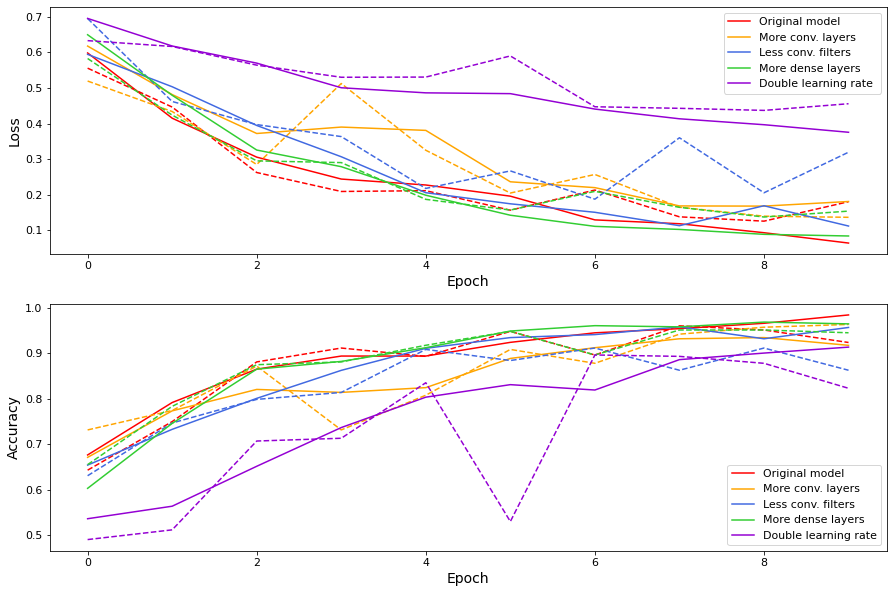

In [74]:
#ploting loss and accuracy function separetaly form the first model
fig, (ax1, ax2) = plt.subplots(2, figsize = (15, 10))
ax1.plot(history.history['loss'], label='Original model ', color="red")
ax1.plot(history.history['val_loss'], color="red",linestyle="dashed")
ax1.plot(history1.history['loss'], label='More conv. layers', color="orange") #train
ax1.plot(history1.history['val_loss'], color="orange",linestyle="dashed") #test
ax1.plot(history2.history['loss'], label='Less conv. filters', color="royalblue")
ax1.plot(history2.history['val_loss'], color="royalblue",linestyle="dashed")
ax1.plot(history3.history['loss'], label='More dense layers', color="limegreen")
ax1.plot(history3.history['val_loss'], color="limegreen",linestyle="dashed")
ax1.plot(history4.history['loss'], label='Double learning rate ', color="darkviolet")
ax1.plot(history4.history['val_loss'], color="darkviolet",linestyle="dashed")
ax1.set_xlabel("Epoch")
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax2.plot(history.history['accuracy'], label='Original model ', color="red")
ax2.plot(history.history['val_accuracy'], color="red",linestyle="dashed")
ax2.plot(history1.history['accuracy'], label='More conv. layers', color="orange") #train
ax2.plot(history1.history['val_accuracy'], color="orange",linestyle="dashed") #test
ax2.plot(history2.history['accuracy'], label='Less conv. filters', color="royalblue")
ax2.plot(history2.history['val_accuracy'], color="royalblue",linestyle="dashed")
ax2.plot(history3.history['accuracy'], label='More dense layers' , color="limegreen")
ax2.plot(history3.history['val_accuracy'], color="limegreen",linestyle="dashed")
ax2.plot(history4.history['accuracy'], label='Double learning rate', color="darkviolet")
ax2.plot(history4.history['val_accuracy'], color="darkviolet",linestyle="dashed")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

#plné čáry označují trénovací dataset a přerušované testovací 

In [70]:
test_loss, test_acc= model.evaluate(x_test, y_test)
test_loss1, test_acc1= model1.evaluate(x_test, y_test)
test_loss2, test_acc2= model2.evaluate(x_test, y_test)
test_loss3, test_acc3= model3.evaluate(x_test, y_test)
test_loss4, test_acc4= model4.evaluate(x_test, y_test)
print("Test accuracy (original model):", test_acc*100, '%')
print("Test accuracy (two more conv. layers):", test_acc1*100, '%')
print("Test accuracy (less conv. filters):", test_acc2*100, '%')
print("Test accuracy (two more dense layers):", test_acc3*100, '%')
print("Test accuracy (double learning rate):", test_acc4*100, '%')
#jako nejlepší modely se ukázaly být ty, ve kterých bylo více konvolučních a dense vrstev
#s přidáním dalších vrstev zvyšujeme počet vah v modelu a ten se nám stává složitější a přesnost se může zlepšovat
#nicméně s malým datasetem může nastat situace overfitování, kde se nám přesnost začně snižovat 

#Při ubrání convolučních filtrů nám pravděpodobnost úspěchu klesla
#jelikož v této konfiguraci model nezaznamená tolik kombinací vzorů v obrázku jako předtím

#nejhůře dopadnul model se zdvojnásobenou velikostí kroku
#což může znamenat, že jsme tak velkým krokem přestřelili minimum naší funkce a tak se vzdálili od nejlepší přesnosti modelu

11/11 [==============================] - 2s 176ms/step - loss: 0.4557 - accuracy: 0.8232
Test accuracy (original model): 92.37805008888245 %
Test accuracy (two more conv. layers): 96.34146094322205 %
Test accuracy (less conv. filters): 86.28048896789551 %
Test accuracy (two more dense layers): 94.51219439506531 %
Test accuracy (double learning rate): 82.31707215309143 %


In [ ]:
#explicit class prediction by our original model
x_pred=model.predict(x_test) 
y_pred=np.argmax(x_pred,axis=1)

print(y_pred[:30]) #predicted classification of furst 30 images in testing dataset
print(y_test[:30]) #validation classification

[0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1]
[0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1]
